<a href="https://colab.research.google.com/github/victorkingbuilder/FlockingHeat/blob/main/Flocking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess # Import lowess for smoothing
import time # Added for performance timing
from sklearn.metrics import silhouette_score, adjusted_rand_score # Added for clustering evaluation and ARI
from sklearn.metrics import mean_squared_error # Added for MSE calculation
from scipy.stats import entropy, gaussian_kde, shapiro # Added for KL divergence, KDE, and Shapiro-Wilk
from scipy.stats import probplot # Added for Q-Q plot

# New imports for comparing clustering methods
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler # For Z-score normalization in clustering preprocessing
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

folder_path = '/content/drive/My Drive/Swarm_Behavior_Data/'

if os.path.exists(folder_path):
   print("Folder found. Files in the folder:")
   print(os.listdir(folder_path))
else:
   print("Folder not found. Please check the path.")

Folder found. Files in the folder:
['Aligned.csv', 'Flocking.csv', 'Grouped.csv']


In [7]:
import pandas as pd

try:
    df_aligned = pd.read_csv(os.path.join(folder_path, 'Aligned.csv'))
    df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))
    df_group = pd.read_csv(os.path.join(folder_path, 'Grouped.csv'))

    print("\nDatasets loaded successfully:")
    print("Aligned dataset head:")
    print(df_aligned.head())
    print("\nFlocking dataset head:")
    print(df_flocking.head())
    print("\nGroup dataset head:")
    print(df_group.head())

except FileNotFoundError:
    print("Error: One or more of the CSV files were not found. Check the file names and path.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

<ipython-input-7-681b4e704af2>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))



Datasets loaded successfully:
Aligned dataset head:
        x1      y1  xVel1  yVel1   xA1  yA1     xS1     yS1   xC1   yC1  ...  \
0 -1414.14 -535.22 -17.88  -7.23  0.00  0.0    0.00    0.00  0.00  0.00  ...   
1 -1412.93  597.54 -13.55  -5.48  0.00  0.0    0.00    0.00  0.00  0.00  ...   
2 -1407.38   70.72 -14.37  -5.81  0.00  0.0    0.00    0.00  0.00  0.00  ...   
3 -1407.00 -759.80  -7.59  -1.27 -0.98 -0.2    0.00    0.00  0.91  0.41  ...   
4 -1406.36  698.39 -16.54  -6.95 -1.00  0.0 -944.07 -396.62  0.00  0.00  ...   

   yVel200  xA200  yA200  xS200  yS200  xC200  yC200  nAC200  nS200  Class  
0   -16.85    0.0   0.00    0.0    0.0   0.00   0.00      29      0      0  
1   -12.09    0.0   0.00    0.0    0.0   0.00   0.00      44      0      0  
2   -16.20    0.0   0.00    0.0    0.0   0.00   0.00      40      0      0  
3     2.99   -1.0  -0.07    0.0    0.0  -0.52   0.86       3      0      1  
4   -12.61    0.0  -1.00    0.0    0.0   0.00   0.00      13      0      0  

[5 

In [8]:
# Explore the columns of each dataframe
print("Columns in df_aligned:")
print(df_aligned.columns)

print("\nColumns in df_flocking:")
print(df_flocking.columns)

print("\nColumns in df_group:")
print(df_group.columns)

Columns in df_aligned:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)

Columns in df_flocking:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class '],
      dtype='object', length=2401)

Columns in df_group:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)


In [9]:
print(df_flocking['x1'].dtypes)
print(df_flocking['x1'].unique())
df_flocking['x1'] = pd.to_numeric(df_flocking['x1'], errors='coerce')
df_flocking.dropna(subset=['x1'], inplace=True)

object
[-1414.14 -1412.93 -1407.38 ... '1404.61' '1406.08' ' ']


In [10]:
print("\nDescriptive statistics for df_flocking:")
print(df_flocking.describe())


Descriptive statistics for df_flocking:
                 x1            y1         xVel1         yVel1           xA1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean     108.280413    -73.075164     -0.737349      0.041626     -0.148095   
std      842.179950    572.563956      6.445383      7.374829      0.377036   
min    -1414.140000  -1012.180000    -18.590000    -18.410000     -1.000000   
25%     -539.665000   -609.365000     -5.520000     -5.710000     -0.230000   
50%      156.010000   -156.710000     -0.460000     -1.600000      0.000000   
75%      898.135000    424.460000      3.820000      7.310000      0.000000   
max     1406.080000   1015.800000     18.470000     18.630000      1.000000   

                yA1           xS1           yS1           xC1           yC1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean       0.150991     -1.217259     -0.835834     -0.035582      0.075811   
std       

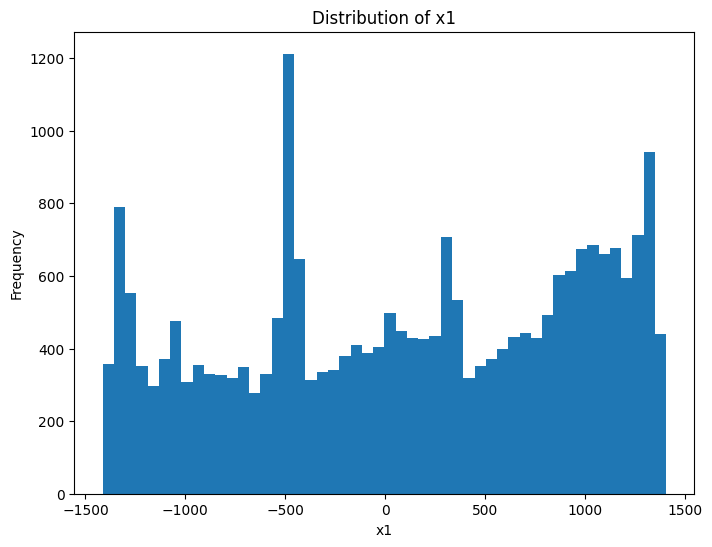

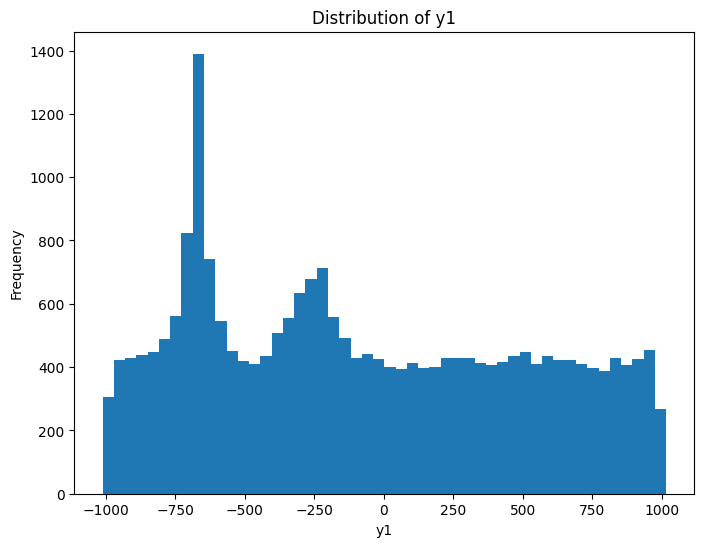

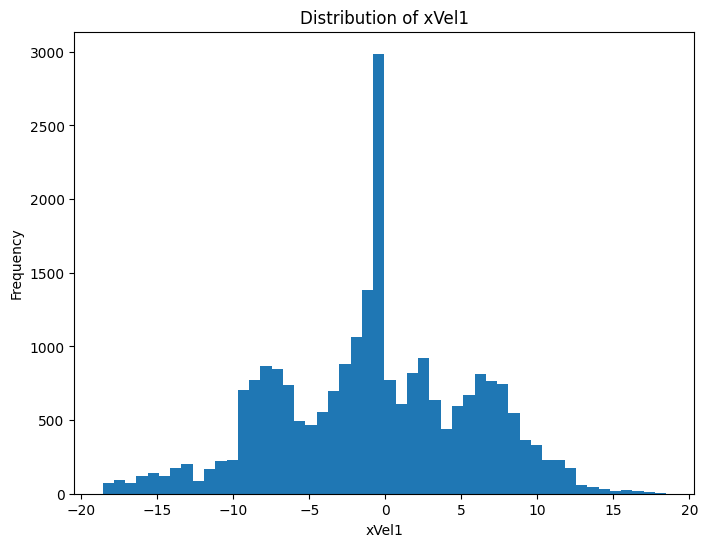

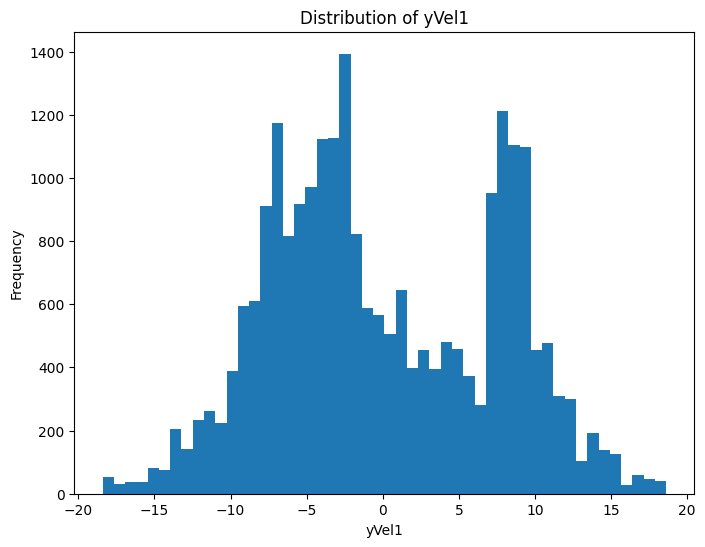

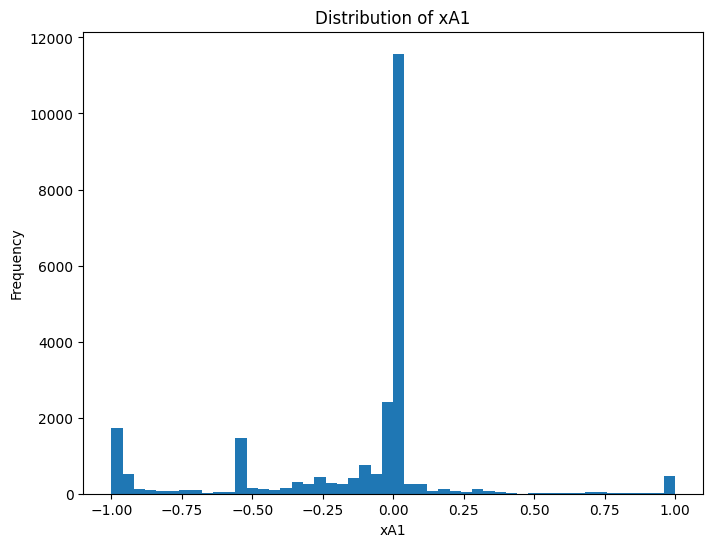

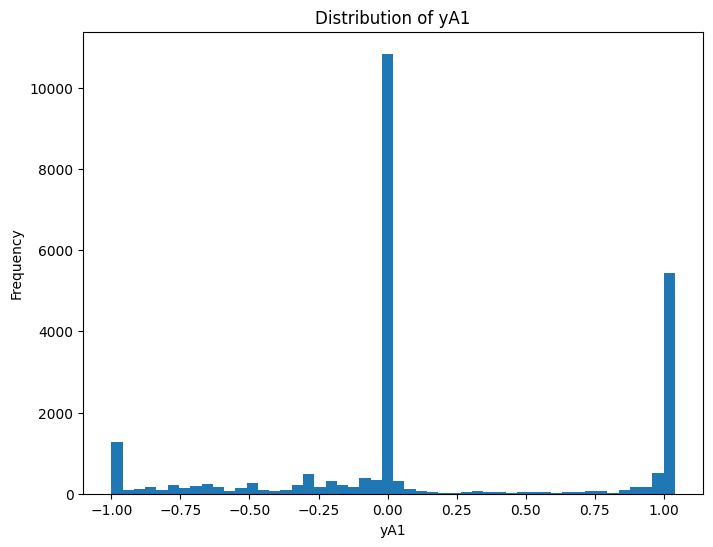

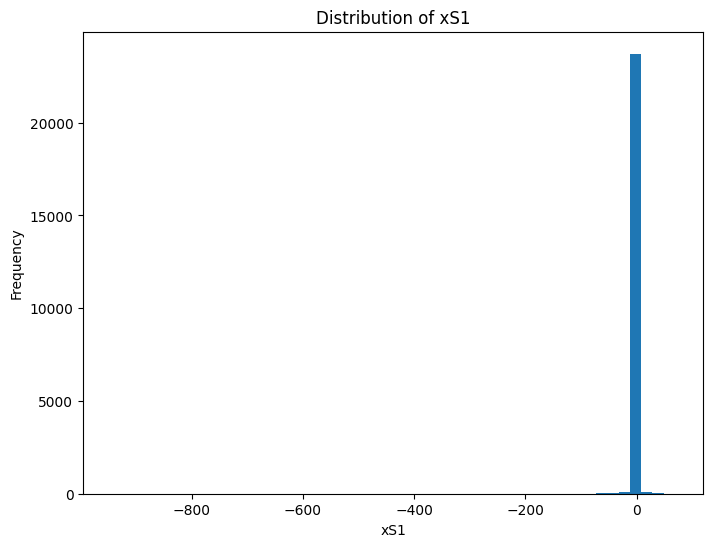

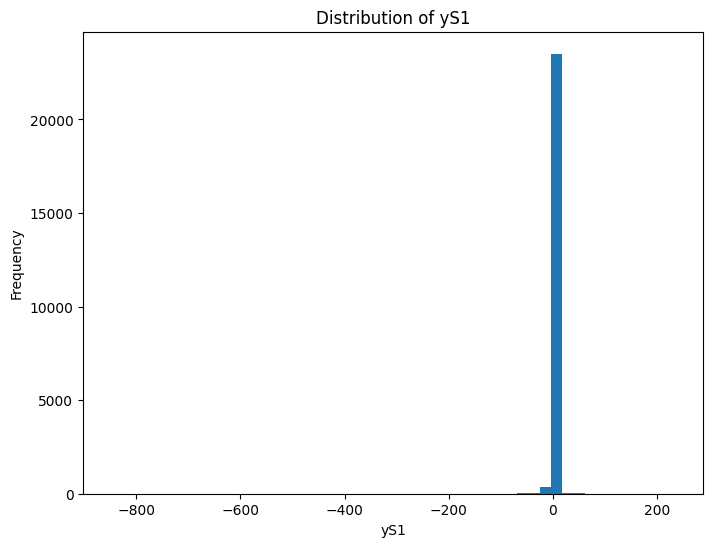

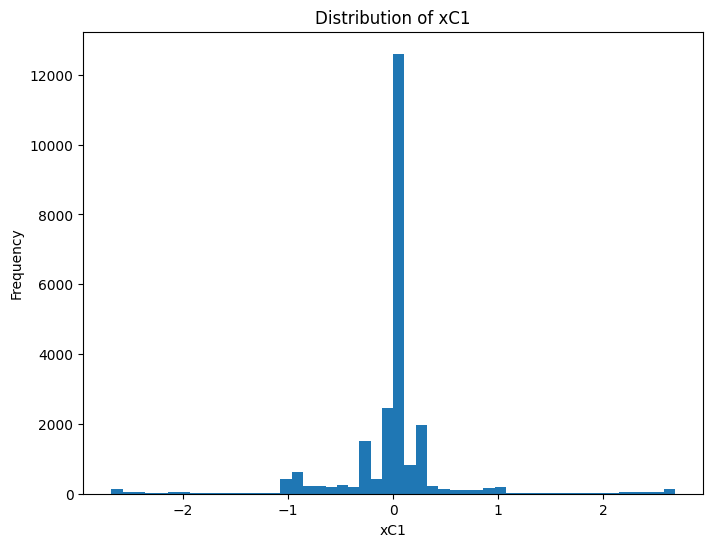

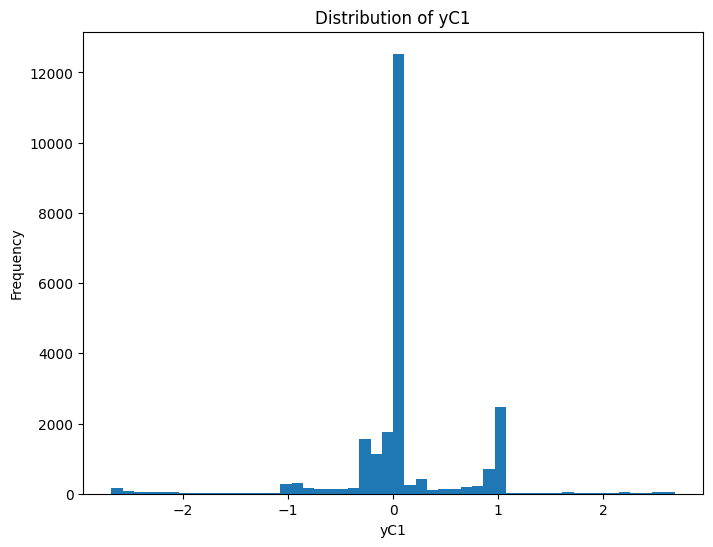

In [11]:
import matplotlib.pyplot as plt

# Choose a few columns you think are relevant to positions, velocities, or distances
# Replace 'column_name_1', 'column_name_2', etc. with actual column names from df_flocking
columns_to_visualize = ['x1','y1','xVel1', 'yVel1','xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1'] # Add more column names here

for col in columns_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")

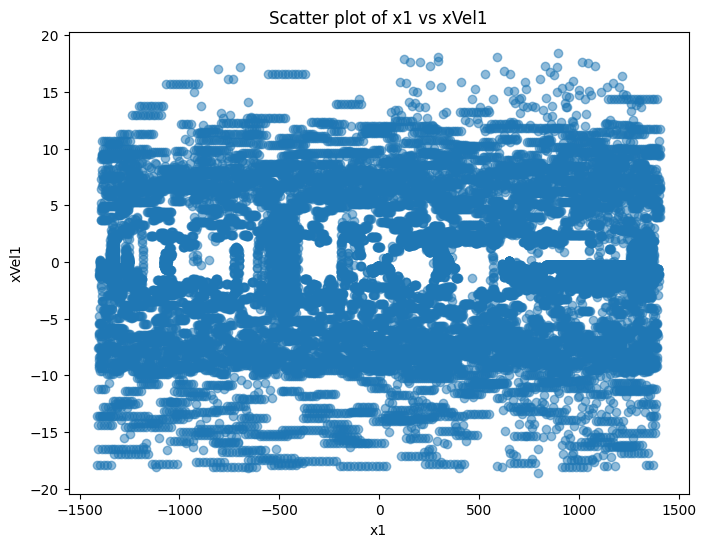

In [12]:
# Choose two columns to plot against each other
# Replace 'feature_1' and 'feature_2' with actual column names from df_flocking
feature_1 = 'x1'
feature_2 = 'xVel1'

if feature_1 in df_flocking.columns and feature_2 in df_flocking.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_flocking[feature_1], df_flocking[feature_2], alpha=0.5)
    plt.title(f'Scatter plot of {feature_1} vs {feature_2}')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()
else:
    print(f"One or both columns '{feature_1}' and '{feature_2}' not found in df_flocking.")

## 1. Average Velocity of the Swarm:
To calculate the average velocity of the swarm at each time step, we took the average of the x and y velocity components across all agents.

In [13]:
# Assuming velocity columns are named xVel1, yVel1, xVel2, yVel2, etc.
# You'll need to adapt this if your column names are different or you have a different number of agents

# Select all columns that represent x and y velocities
x_vel_cols = [col for col in df_flocking.columns if 'xVel' in col]
y_vel_cols = [col for col in df_flocking.columns if 'yVel' in col]

# Calculate the average x and y velocity across all agents
df_flocking['avg_x_velocity'] = df_flocking[x_vel_cols].mean(axis=1)
df_flocking['avg_y_velocity'] = df_flocking[y_vel_cols].mean(axis=1)

# Calculate the magnitude of the average velocity
df_flocking['avg_velocity_magnitude'] = np.sqrt(df_flocking['avg_x_velocity']**2 + df_flocking['avg_y_velocity']**2)

print("\nAverage velocity columns added to df_flocking:")
print(df_flocking[['avg_x_velocity', 'avg_y_velocity', 'avg_velocity_magnitude']].head())


Average velocity columns added to df_flocking:
   avg_x_velocity  avg_y_velocity  avg_velocity_magnitude
0        -3.14935        -7.72905                8.346054
1        -3.28055        -7.73925                8.405831
2        -2.86450        -7.24115                7.787144
3        -6.41290        -0.66785                6.447582
4        -3.52935        -6.26410                7.189942


## 2. Average Distance Between Agents:
We calculated the average distance by first calculating the average distance of each agent to the center of the swarm.

First, let's calculate the center of the swarm (average x and y position).

In [14]:
# Since our position columns are named x1, y1, x2, y2, etc. You'll need to adapt

# Select all columns that represent x and y positions
x_pos_cols = [col for col in df_flocking.columns if col.startswith('x') and col[1:].isdigit()]
y_pos_cols = [col for col in df_flocking.columns if col.startswith('y') and col[1:].isdigit()]


# Calculate the average x and y position across all agents (center of the swarm)
df_flocking['swarm_center_x'] = df_flocking[x_pos_cols].mean(axis=1)
df_flocking['swarm_center_y'] = df_flocking[y_pos_cols].mean(axis=1)

# Now, calculate the distance of each agent to the swarm center and then average
distances_to_center = []
for i in range(1, 201): # Assuming up to 200 agents
    x_col = f'x{i}'
    y_col = f'y{i}'
    if x_col in df_flocking.columns and y_col in df_flocking.columns:
        distance = np.sqrt((df_flocking[x_col] - df_flocking['swarm_center_x'])**2 + (df_flocking[y_col] - df_flocking['swarm_center_y'])**2)
        distances_to_center.append(distance)

# Calculate the average distance to the center across all agents
df_flocking['avg_distance_to_center'] = pd.concat(distances_to_center, axis=1).mean(axis=1)

print("\nAverage distance to center column added to df_flocking:")
print(df_flocking[['swarm_center_x', 'swarm_center_y', 'avg_distance_to_center']].head())


Average distance to center column added to df_flocking:
   swarm_center_x  swarm_center_y  avg_distance_to_center
0        57.40820       -34.12215              942.503578
1       -39.07540       -67.15180              953.482680
2         3.66115        36.63670              912.604185
3       122.77625        54.35525              935.923303
4        77.15310        12.23910              929.381731


In [15]:
# 1. Calculate headings and cosines in separate DataFrames
heading_data = {}
cos_heading_data = {}

for i in range(1, 201): # Assuming up to 200 agents
    x_vel_col = f'xVel{i}'
    y_vel_col = f'yVel{i}'
    if x_vel_col in df_flocking.columns and y_vel_col in df_flocking.columns:
        heading_data[f'heading_{i}'] = np.arctan2(df_flocking[y_vel_col], df_flocking[x_vel_col])
        cos_heading_data[f'cos_heading_{i}'] = np.cos(heading_data[f'heading_{i}'])

# Convert dictionaries to DataFrames
headings_df = pd.DataFrame(heading_data)
cos_headings_df = pd.DataFrame(cos_heading_data)

# 2. Concatenate the new DataFrames to the original DataFrame
df_flocking = pd.concat([df_flocking, headings_df, cos_headings_df], axis=1)

# 3. Calculate the average cosine of the headings across all agents
heading_cos_cols = [col for col in df_flocking.columns if col.startswith('cos_heading_')]
df_flocking['avg_alignment'] = df_flocking[heading_cos_cols].mean(axis=1)

print("\nAverage alignment column added to df_flocking:")
print(df_flocking[['avg_alignment']].head())


Average alignment column added to df_flocking:
   avg_alignment
0      -0.264251
1      -0.264271
2      -0.264238
3      -0.764597
4      -0.304358


## Explorative Analysis of the New Average Columns

In [16]:
print("\nDescriptive statistics for aggregate swarm features:")
print(df_flocking[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].describe())


Descriptive statistics for aggregate swarm features:
       avg_velocity_magnitude  avg_distance_to_center  avg_alignment
count            24015.000000            24015.000000   24015.000000
mean                 5.818939              873.431710      -0.167521
std                  2.802965              109.143974       0.325980
min                  0.003963              312.513907      -0.983973
25%                  3.636368              832.210950      -0.263027
50%                  6.230279              904.874754      -0.079180
75%                  8.095412              935.477742      -0.001766
max                 11.714667             1396.118340       0.511052


## Visualize Distributions (Histograms)

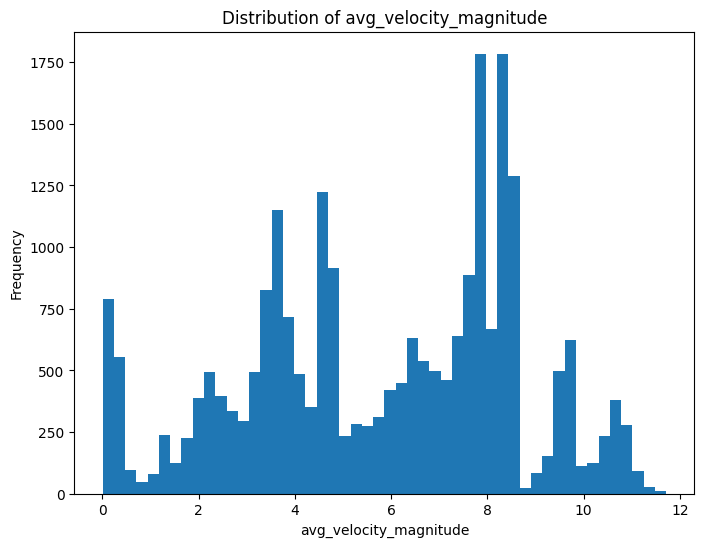

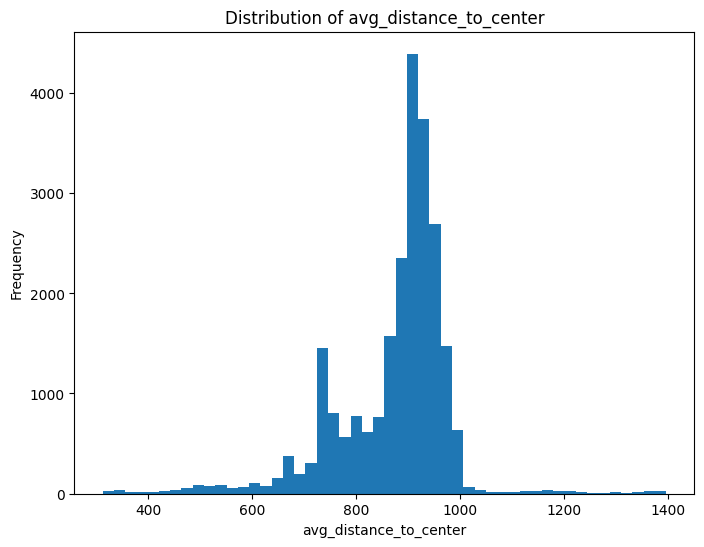

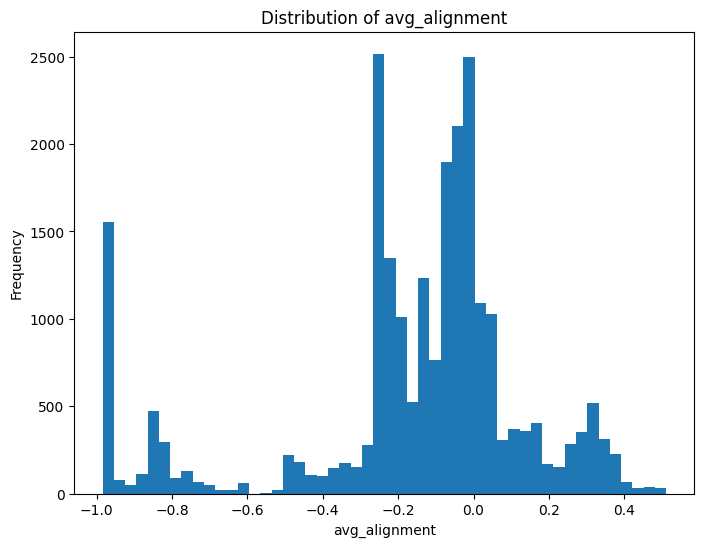

In [17]:
import matplotlib.pyplot as plt

aggregate_cols_to_visualize = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

for col in aggregate_cols_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")


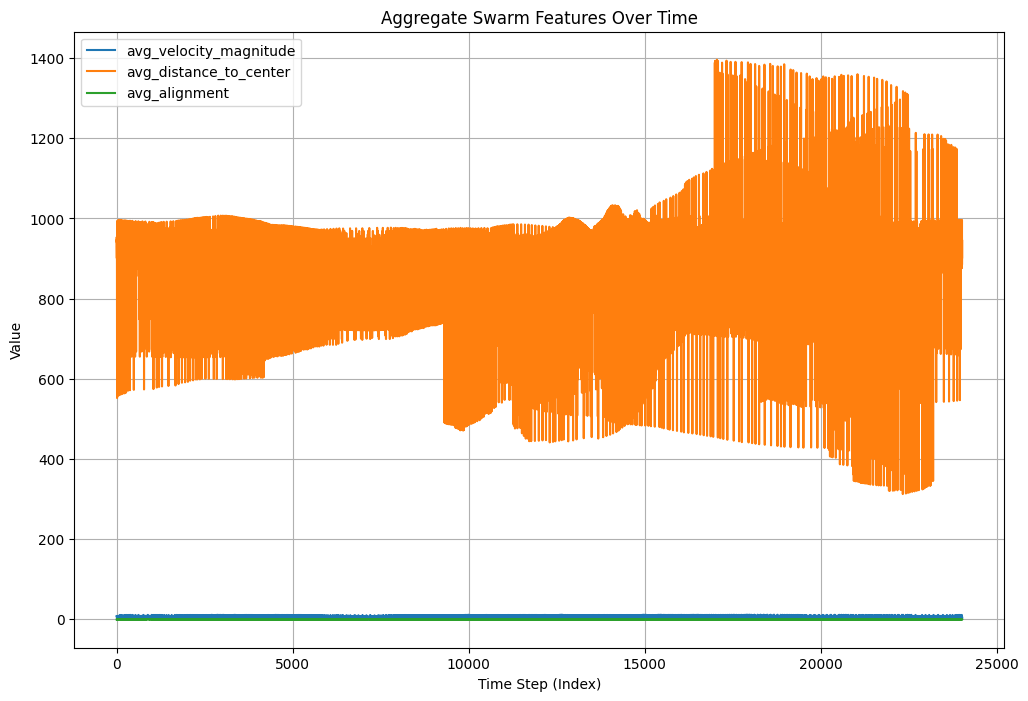

In [20]:
import matplotlib.pyplot as plt

aggregate_cols_to_plot = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

plt.figure(figsize=(12, 8))
for col in aggregate_cols_to_plot:
    if col in df_flocking.columns:
        plt.plot(df_flocking.index, df_flocking[col], label=col) # Assuming time is represented by the index
    else:
        print(f"Column '{col}' not found in df_flocking.")

plt.title('Aggregate Swarm Features Over Time')
plt.xlabel('Time Step (Index)') # Adjust label if you have a specific time column
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Ensure all arrays have the same length for combination
# Access the columns directly from the DataFrame
min_len = min(len(df_flocking['avg_velocity_magnitude']), len(df_flocking['avg_distance_to_center']), len(df_flocking['avg_alignment']))

data = pd.DataFrame({
    'avg_velocity_magnitude': df_flocking['avg_velocity_magnitude'][:min_len],
    'avg_distance_to_center': df_flocking['avg_distance_to_center'][:min_len],
    'avg_alignment': df_flocking['avg_alignment'][:min_len]
})

print(f"Synthetic data shape: {data.shape}")
print(data.head())

Synthetic data shape: (24015, 3)
   avg_velocity_magnitude  avg_distance_to_center  avg_alignment
0                8.346054              942.503578      -0.264251
1                8.405831              953.482680      -0.264271
2                7.787144              912.604185      -0.264238
3                6.447582              935.923303      -0.764597
4                7.189942              929.381731      -0.304358


In [22]:
# --- 2. Preprocess Data (Important for GMMs) ---
# It's highly recommended to scale our features, especially if they are on different scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)



In [25]:
# --- 3. Determine Range of Components to Test ---
n_components_range = range(1, 15) # Test from 1 to 14 components

# --- 4. Fit GMMs and Calculate BIC/AIC ---
bic = []
aic = []
lowest_bic = np.inf
best_gmm = None

for n_components in n_components_range:
    # Define a GMM model
    # covariance_type='full' is the default and most flexible
    # max_iter can be increased if convergence issues arise
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

    # Fit the model to the scaled data
    gmm.fit(X_scaled)

    # Calculate BIC and AIC
    bic.append(gmm.bic(X_scaled))
    aic.append(gmm.aic(X_scaled))

    # Keep track of the best GMM based on BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

print(f"\nOptimal number of components according to BIC: {best_gmm.n_components}")




Optimal number of components according to BIC: 14


In [27]:
cluster_labels = best_gmm.predict(X_scaled)
data['cluster_label'] = cluster_labels

In [28]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            7.277666              900.597326      -0.824237
1                            3.933459              922.447191      -0.139634
2                            2.699689              660.199957       0.076446
3                            8.899048              926.991113      -0.026827
4                           10.581913              891.401929       0.313331
5                            8.457994              790.054844      -0.032697
6                            0.235559              731.654686       0.010271
7                            6.372496              895.625886      -0.198947
8                            2.058433              924.575542       0.086854
9                            5.498109              508.709524       0.365733
10                       

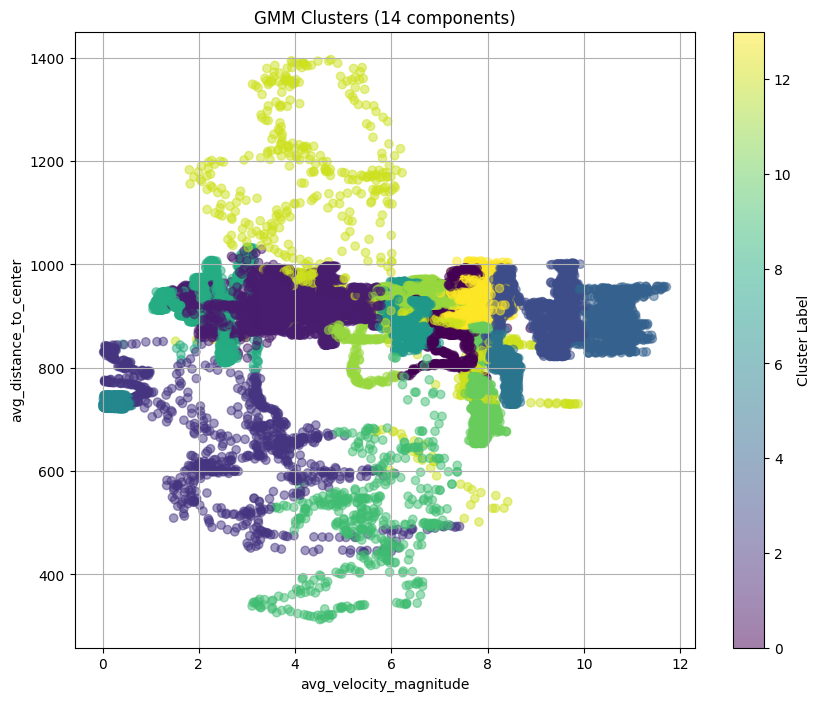

In [30]:
import matplotlib.pyplot as plt

# You can choose any two of your aggregate features to plot
feature1 = 'avg_velocity_magnitude'
feature2 = 'avg_distance_to_center'

plt.figure(figsize=(10, 8))
plt.scatter(data[feature1], data[feature2], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'GMM Clusters ({best_gmm.n_components} components)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# You can create similar plots for other pairs of features


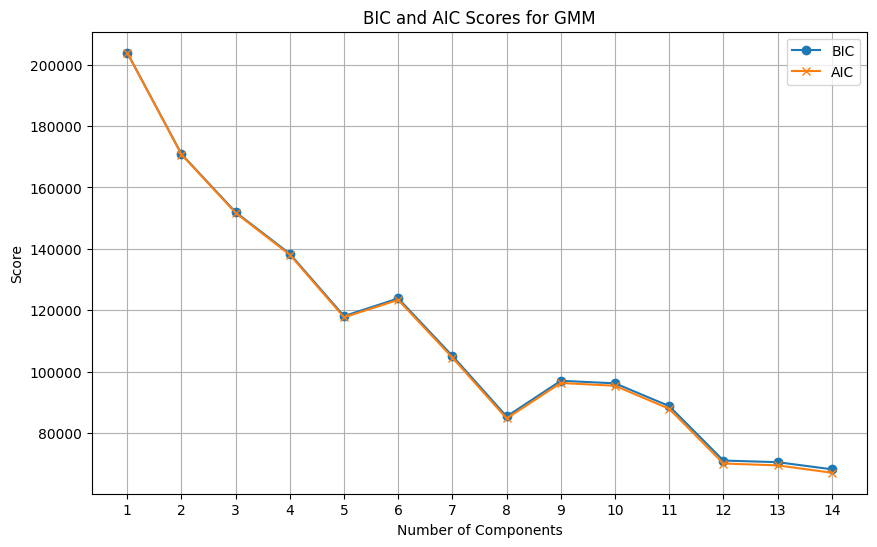

AttributeError: 'GaussianMixture' object has no attribute 'n_components_'

In [26]:
# --- 5. Visualize BIC and AIC ---
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.plot(n_components_range, aic, marker='x', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Further analysis with the best GMM ---
if best_gmm:
    print(f"\n--- Analysis with Best GMM ({best_gmm.n_components_} components) ---")
    # Predict clusters for your data
    cluster_labels = best_gmm.predict(X_scaled)
    data['cluster_label'] = cluster_labels
    print("Cluster assignments for the first 10 data points:")
    print(data.head(10)[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment', 'cluster_label']])

    # You can also inspect the means and covariances of the components
    print("\nMeans of the components (scaled features):")
    print(best_gmm.means_)
    print("\nCovariances of the components (first component's covariance matrix):")
    print(best_gmm.covariances_[0]) # Example: print covariance of the first component

    # To get means back to original scale (approximate, more complex for non-diagonal covariance)
    original_scale_means = scaler.inverse_transform(best_gmm.means_)
    print("\nMeans of the components (approx. original scale):")
    print(original_scale_means)

    # You can now analyze the characteristics of each cluster/component
    # For example, mean values of original features for each cluster
    print("\nMean feature values per cluster (original scale):")
    print(data.groupby('cluster_label').mean())